In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from scipy.constants import c as speed_of_light
from tqdm import tqdm
from numba import njit, jit, prange
from numba.typed import List
import time
from scipy.stats import mode
from numba.typed import List

In [2]:
@njit
def calc_flux(wl, flux, wlrange):
    """
    Calculates the flux of a flux density in Jy over a range of wavelengths in microns
    """
    mask = (wl >= wlrange[0]) & (wl <= wlrange[1])
    return total_flux(wl[mask], flux[mask])


@njit
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    if wl.size == 0:
        return 0
    flux_lambda = (speed_of_light * 100 / (wl * 1e-4) ** 2) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux


def compress_to_numpy(model_names, species, df):
    dim1 = len(model_names)
    dim2 = len(species)

    arr = []

    for i, model_name in enumerate(model_names):
        row = []
        for j, species_name in enumerate(species):
            wavelength = df.loc[df['Model Name'] == model_name, f'FLiTs {species_name} Wavelength'].values[0]
            flux = df.loc[df['Model Name'] == model_name, f'FLiTs {species_name} Flux'].values[0]
            row.append((wavelength, flux))
        arr.append(row)

    numba_list = List()
    for row in arr:
        numba_row = List()
        for item in row:
            numba_row.append(item)
        numba_list.append(numba_row)

    return numba_list


@njit(parallel=True, fastmath=True)
def spectral_window(min_wl, max_wl, window_size, arr):
    windows_array = np.arange(min_wl, max_wl, window_size)
    num_models = len(arr)
    num_windows = len(windows_array)

    dom = np.full((num_models, num_windows), -1, dtype=np.int32)

    # Parallelize the outer loop using prange
    for i in prange(num_models):
        for index_window in range(num_windows):
            window_start = windows_array[index_window]
            window_end = window_start + window_size

            max_flux = -np.inf
            dominant_specie_index = -1

            for j in range(len(arr[i])):
                wavelength, flux = arr[i][j]

                flux_value = calc_flux(wavelength, flux, [window_start, window_end])

                if flux_value > max_flux:
                    max_flux = flux_value
                    dominant_specie_index = j

            dom[i, index_window] = dominant_specie_index

    return windows_array, dom

In [3]:
# Open the data 
with open('ModelData.pkl', 'rb') as f:
    df = pickle.load(f)
df.head()

,Model Name,C Value,O Value,CO Value,FLiTs Wavelength,FLiTs Flux,ProDiMo C2H2_H,ProDiMo CH4_H,ProDiMo CO,ProDiMo CO2_H,...,FLiTs HCN Flux,FLiTs HCN Wavelength,FLiTs NH3 Flux,FLiTs NH3 Wavelength,FLiTs NO Flux,FLiTs NO Wavelength,FLiTs O2 Flux,FLiTs O2 Wavelength,FLiTs OH Flux,FLiTs OH Wavelength
0,C_-0.5_O_-0.5_CO_0.45,-0.5,-0.5,0.45,"[4.90216873, 4.90218508, 4.90220144, 4.9022177...","[9.290666707434392e-05, 9.36347640732027e-05, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.009307341873190812, 0.0025946503251030473, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[6.378495698844411e-07, 6.387100354166009e-07,...","[6.28443468, 6.28445564, 6.2844766, 6.28449757...","[0.0, -5.551115123125783e-17, -5.5511151231257...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[3.0270818582311954e-06, 3.139984831007636e-06...","[4.94498186, 4.94499836, 4.94501485, 4.9450313...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.82143071, 5.82145013, 5.82146955, 5.8214889...","[1.0257067417640542e-09, 1.0500832980930852e-0...","[5.04256821, 5.04258503, 5.04260185, 5.0426186..."
1,C_-0.5_O_-0.25_CO_0.2570,-0.5,-0.25,0.2570,"[4.90218508, 4.90220144, 4.90221779, 4.9022341...","[0.00019233132506346617, 0.0001931775592640128...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.009973783312290348, 0.0027809342451176797, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[5.06837770697377e-07, 5.073831906843296e-07, ...","[6.28443468, 6.28445564, 6.2844766, 6.28449757...","[-1.6653345369377348e-16, -1.1102230246251565e...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[2.7634031990464436e-06, 2.8559108257997234e-0...","[4.94499836, 4.94501485, 4.94503135, 4.9450478...","[0.0, 0.0, 0.0, 0.0, 5.551115123125783e-17, 0....","[5.82145013, 5.82146955, 5.82148897, 5.8215083...","[1.2735189014456694e-09, 1.3046404512273568e-0...","[5.04258503, 5.04260185, 5.04261867, 5.0426354..."
2,C_-0.5_O_0.0_CO_0.145,-0.5,0.0,0.145,"[4.90221779, 4.90222315, 4.9022395, 4.90225585...","[0.000367419622368359, 0.0003677125852135088, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.010834020451426084, 0.0030209004637909826, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[3.5582955781876535e-07, 3.561846355637499e-07...","[6.28443468, 6.28445564, 6.2844766, 6.28449757...","[-1.6653345369377348e-16, -2.220446049250313e-...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[2.5292308538926722e-06, 2.6050974119562476e-0...","[4.94501485, 4.94503135, 4.94504784, 4.9450643...","[-5.551115123125783e-17, -5.551115123125783e-1...","[5.82148897, 5.82150839, 5.82152781, 5.8215472...","[2.0780795417785214e-09, 2.121000819421681e-09...","[5.04258503, 5.04260185, 5.04261867, 5.0426354..."
3,C_-0.5_O_0.25_CO_0.0813,-0.5,0.25,0.0813,"[4.9022395, 4.90225585, 4.9022722, 4.90228855,...","[0.0006806647851314573, 0.0006815528527352455,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01228869544251925, 0.0034253443431899017, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[2.4586606944820844e-07, 2.4621352973097643e-0...","[6.28445564, 6.2844766, 6.28449757, 6.28451853...","[-1.1102230246251565e-16, -5.551115123125783e-...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[1.6157067910249623e-06, 1.6620520339460931e-0...","[4.94503135, 4.94504784, 4.94506434, 4.9450808...","[1.6653345369377348e-16, 2.220446049250313e-16...","[5.82150839, 5.82152781, 5.82154722, 5.8215666...","[2.173648039338616e-09, 2.220975070521547e-09,...","[5.04261867, 5.04263549, 5.04265231, 5.0426691..."
4,C_-0.5_O_0.5_CO_0.045,-0.5,0.5,0.045,"[4.90225585, 4.9022722, 4.90228855, 4.90230491...","[0.001111040302178401, 0.001111295774154919, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [4]:
model_names = np.array(df['Model Name'])
species = ['atomic', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
min_wl = 4.9
max_wl = 28.6
window_size = .01

arr = compress_to_numpy(model_names, species, df)
start_time = time.time()
windows, dominant = spectral_window(min_wl, max_wl, window_size, arr)
end_time = time.time()
print(f'time taken for computation:{end_time - start_time:.1f}')

C:\Users\niels\AppData\Local\Temp\ipykernel_10412\2986252985.py:63: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  for j in range(len(arr[i])):


time taken for computation:53.2


['atomic', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']


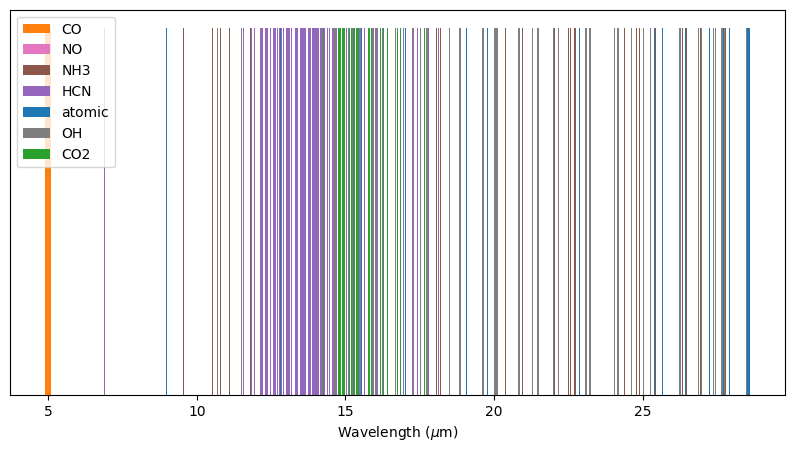

In [5]:
majority_values = mode(dominant, axis=0).mode
print([species[i] for i in np.unique(majority_values)])
colors = plt.colormaps["tab10"].colors[:len(np.unique(majority_values))]
name_colors = dict(zip(np.unique(majority_values), colors))
new_species = species + ['Different']

plt.figure(figsize=(10, 5))
for i in range(len(windows)):
    if new_species[majority_values[i]] != 'H2O':
        plt.bar(windows[i], 1, width=window_size, color=name_colors[majority_values[i]], label=new_species[majority_values[i]])

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())
plt.xlabel('Wavelength ($\mu$m)')
plt.yticks([])

# plt.xlim(4.9, 5.2)
plt.savefig('Spectral_regions.pdf')
plt.show()